# Colab Setup 

In [0]:
!nvidia-smi

Wed Sep 25 12:50:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install gdown --quiet

In [0]:
!pip install pyts --quiet

     |████████████████████████████████| 2.5MB 2.9MB/s 


In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


# Imports and Data Setup

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np  
import pandas as pd
from pathlib import Path
import scipy.io
import h5py

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from scipy.signal import resample

from pathlib import Path

from scipy.signal import find_peaks as findPeaks
from scipy import sparse
from scipy.sparse.linalg import spsolve

import gdown

from fastai import *
from fastai.vision import *
from fastai.callbacks.tracker import SaveModelCallback

In [0]:
datapath = Path('./data')

In [0]:
basepath = Path('.')

In [0]:
rawpath = Path('./raw')

In [0]:
# Download Raw Data
inertial_url = 'https://drive.google.com/uc?export=download&id=1gGd3nq889m9iU8gkyqk1YHLOqmR31VWb'
inertial_file = 'Inertial.zip'

skeleton_url = 'https://drive.google.com/uc?export=download&id=1rvnhTitWIWF-9biYyzzGXXcaY5BXecV1'
skeleton_file = 'Skeleton.zip'

gdown.download(inertial_url, inertial_file, quiet=True)
gdown.download(skeleton_url, skeleton_file, quiet=True)

'Skeleton.zip'

In [0]:
!unzip -qq ./Inertial.zip -d ./raw

In [0]:
!unzip -qq ./Skeleton.zip -d ./raw

## Helper Functions

In [0]:
def import_data(file_type, action, subject, trial):
    filename = rawpath/f'{file_type}/a{action}_s{subject}_t{trial}_{file_type.lower()}.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        if file_type.lower() == 'inertial':
            return mat['d_iner']
        else:
            return mat['d_skel']
    else:
        return None

In [0]:
def calculate_angle(point1,point2,point3):


    point2_1 = point1 - point2
    point2_3 = point3 - point2

    cosine_angle = np.dot(point2_1, point2_3) / (np.linalg.norm(point2_1) * np.linalg.norm(point2_3))
    angle = np.arccos(cosine_angle)
    angle = np.degrees(angle)

    return angle

## Preprocess Data

In [0]:
# Importing Skeleton Data Variance
def process_skeleton_angles():

    reshaped_data = np.zeros([861,116,60])
    trDat = []
    trLbl = []
    tsDat = []
    tsLbl = []
 
    index = 0
    counter = 0
    subject = 0

    for i in range (864):
        
        if counter == 32:
            counter = 0
        subject = int((counter-counter%4)/4+1)
        counter = counter + 1
        action = int((i-i%32)/32+1)
        take = i%4+1
        
        data = import_data('Skeleton',action,subject,take)
        
        
        if data is not None:
                        
            temp_array = np.zeros([data.shape[2],60])
            temp_array_angle = np.zeros([12,data.shape[2]])
            
            for j in range (data.shape[2]):
                temp_array[j,:] = data[:,:,j].flatten()
                
                temp_array_angle[0,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,6:8]) #head_spine_angle
                temp_array_angle[1,j]= calculate_angle(temp_array[j,3:5],temp_array[j,6:8],temp_array[j,9:11]) #spine_angle
                
                temp_array_angle[2,j]= calculate_angle(temp_array[j,15:17],temp_array[j,18:20],temp_array[j,21:23]) #left_wrist_angle
                temp_array_angle[3,j]= calculate_angle(temp_array[j,13:14],temp_array[j,15:17],temp_array[j,18:20]) #left_elbow_angle
                temp_array_angle[4,j]= calculate_angle(temp_array[j,3:5],temp_array[j,12:14],temp_array[j,15:17]) #left_shoulder_angle
                #temp_array_angle[5,j]= calculate_angle(temp_array[j,39:41],temp_array[j,42:44],temp_array[j,45:47]) #left_ankle_angle
                temp_array_angle[5,j]= calculate_angle(temp_array[j,36:38],temp_array[j,39:41],temp_array[j,42:44]) #left_knee_angle
                temp_array_angle[6,j]= calculate_angle(temp_array[j,9:11],temp_array[j,36:38],temp_array[j,39:41]) #left_hip_angle
                #temp_array_angle[7,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,12:14]) #left_shoulder_head_angle
                temp_array_angle[7,j]= calculate_angle(temp_array[j,27:29],temp_array[j,30:32],temp_array[j,33:35]) #right_wrist_angle
                temp_array_angle[8,j]= calculate_angle(temp_array[j,24:26],temp_array[j,27:29],temp_array[j,30:32]) #right_elbow_angle
                temp_array_angle[9,j]= calculate_angle(temp_array[j,3:5],temp_array[j,24:26],temp_array[j,27:29]) #right_shoulder_angle
                #temp_array_angle[10,j]= calculate_angle(temp_array[j,51:53],temp_array[j,54:56],temp_array[j,57:59]) #right_ankle_angle
                temp_array_angle[10,j]= calculate_angle(temp_array[j,48:50],temp_array[j,51:53],temp_array[j,54:56]) #right_knee_angle
                temp_array_angle[11,j]= calculate_angle(temp_array[j,9:11],temp_array[j,48:50],temp_array[j,51:53]) #right_hip_angle
                #temp_array_angle[13,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,24:26]) #right_shoulder_head_angle
            
            variance_array = []
            for k in range (12):
                variance_array.append(np.var(temp_array_angle[k]))
            
                
            
            if subject in [2, 4, 6, 8]:
                
                tsDat.append(variance_array)
                tsLbl.append(action-1)
               
            elif subject in [1, 3, 5, 7]:

                trDat.append(variance_array)
                trLbl.append(action-1)
       
                
            index = index + 1
   
    trDat = np.array(trDat)
    trLbl = np.array(trLbl)
    tsDat = np.array(tsDat)
    tsLbl = np.array(tsLbl)
 
    return trDat, trLbl, tsDat, tsLbl

trDat, trLbl, tsDat, tsLbl = process_skeleton_angles()

print(trDat.shape)
print(trLbl.shape)
print(tsDat.shape)
print(tsLbl.shape)

(431, 12)
(431,)
(430, 12)
(430,)


In [0]:
# Importing area under the curve which is affected by speed of action execution
# Importing Angular displacement which is not affected by speed og action execution
# Compute Maximum Amplitude
# Compute Number of peaks

def process_skeleton_peaks():

    reshaped_data = np.zeros([861,116,60])
    trDat_a = []
    trLbl_a = []
    tsDat_a = []
    tsLbl_a = []
 
    index = 0
    counter = 0
    subject = 0

    for i in range (864):
        
        if counter == 32:
            counter = 0
        subject = int((counter-counter%4)/4+1)
        counter = counter + 1
        action = int((i-i%32)/32+1)
        take = i%4+1
        
        data = import_data('Skeleton',action,subject,take)
        
        
        if data is not None:
                        
            temp_array = np.zeros([data.shape[2],60])
            temp_array_angle = np.zeros([12,data.shape[2]])
            
            for j in range (data.shape[2]):
                temp_array[j,:] = data[:,:,j].flatten()
                
                temp_array_angle[0,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,6:8]) #head_spine_angle
                temp_array_angle[1,j]= calculate_angle(temp_array[j,3:5],temp_array[j,6:8],temp_array[j,9:11]) #spine_angle
                
                temp_array_angle[2,j]= calculate_angle(temp_array[j,15:17],temp_array[j,18:20],temp_array[j,21:23]) #left_wrist_angle
                temp_array_angle[3,j]= calculate_angle(temp_array[j,13:14],temp_array[j,15:17],temp_array[j,18:20]) #left_elbow_angle
                temp_array_angle[4,j]= calculate_angle(temp_array[j,3:5],temp_array[j,12:14],temp_array[j,15:17]) #left_shoulder_angle
                #temp_array_angle[5,j]= calculate_angle(temp_array[j,39:41],temp_array[j,42:44],temp_array[j,45:47]) #left_ankle_angle
                temp_array_angle[5,j]= calculate_angle(temp_array[j,36:38],temp_array[j,39:41],temp_array[j,42:44]) #left_knee_angle
                temp_array_angle[6,j]= calculate_angle(temp_array[j,9:11],temp_array[j,36:38],temp_array[j,39:41]) #left_hip_angle
                #temp_array_angle[7,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,12:14]) #left_shoulder_head_angle
                temp_array_angle[7,j]= calculate_angle(temp_array[j,27:29],temp_array[j,30:32],temp_array[j,33:35]) #right_wrist_angle
                temp_array_angle[8,j]= calculate_angle(temp_array[j,24:26],temp_array[j,27:29],temp_array[j,30:32]) #right_elbow_angle
                temp_array_angle[9,j]= calculate_angle(temp_array[j,3:5],temp_array[j,24:26],temp_array[j,27:29]) #right_shoulder_angle
                #temp_array_angle[10,j]= calculate_angle(temp_array[j,51:53],temp_array[j,54:56],temp_array[j,57:59]) #right_ankle_angle
                temp_array_angle[10,j]= calculate_angle(temp_array[j,48:50],temp_array[j,51:53],temp_array[j,54:56]) #right_knee_angle
                temp_array_angle[11,j]= calculate_angle(temp_array[j,9:11],temp_array[j,48:50],temp_array[j,51:53]) #right_hip_angle
                #temp_array_angle[13,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,24:26]) #right_shoulder_head_angle

            
            new_feature_array = []
            area_under_the_curve = 0
            for k in range (12):
                
                #Calculate number of peaks
                J1= temp_array_angle[k]
                (allPks,_) = findPeaks(J1,prominence=20,width=1)
                new_feature_array.append(len(allPks))
            
            
            if subject in [2, 4, 6, 8]:
                
                tsDat_a.append(new_feature_array)
                tsLbl_a.append(action-1)
               
            elif subject in [1, 3, 5, 7]:

                trDat_a.append(new_feature_array)
                trLbl_a.append(action-1)
       
                
            index = index + 1
   
    trDat_a = np.array(trDat_a)
    trLbl_a = np.array(trLbl_a)
    tsDat_a = np.array(tsDat_a)
    tsLbl_a = np.array(tsLbl_a)
 
    return trDat_a, trLbl_a, tsDat_a, tsLbl_a

trDat_a, trLbl_a, tsDat_a, tsLbl_a = process_skeleton_peaks()

print(trDat_a.shape)
print(trLbl_a.shape)
print(tsDat_a.shape)
print(tsLbl_a.shape)

(431, 12)
(431,)
(430, 12)
(430,)


In [0]:
trDat = np.concatenate((trDat, trDat_a), axis = -1)
tsDat = np.concatenate((tsDat, tsDat_a), axis = -1)

print(trDat.shape)
print(trLbl.shape)
print(tsDat.shape)
print(tsLbl.shape)

(431, 24)
(431,)
(430, 24)
(430,)


In [0]:
# Importing Inertia Data 6 Features
def process_inertial_variance():

    i_trDat = []
    i_trLbl = []
    i_tsDat = []
    i_tsLbl = []

    index1 = 0
    index2 = 0
    counter = 0
    subject = 0
    for i in range (864):
        
        if counter == 32:
            counter = 0
        subject = int((counter-counter%4)/4+1)
        counter = counter + 1
        action = int((i-i%32)/32+1)
        take = i%4+1
        
        data = import_data('Inertial',action,subject,take)
        
        
        if data is not None:
            
            temp_array = np.zeros([6,data.shape[0]])
            for j in range (data.shape[0]):
                temp_array[0][j]=data[j][0]
                temp_array[1][j]=data[j][1]
                temp_array[2][j]=data[j][2]
                temp_array[3][j]=data[j][3]
                temp_array[4][j]=data[j][4]
                temp_array[5][j]=data[j][5]
                
            variance_array = []
            for k in range (6):
                variance_array.append(np.var(temp_array[k]))
                                          
            
            if subject in [2, 4, 6, 8]:
                i_tsDat.append(variance_array)
                i_tsLbl.append(action-1)
                index1 = index1 + 1 
            elif subject in [1, 3, 5, 7]:
                i_trDat.append(variance_array)
                i_trLbl.append(action-1)
                index2 = index2 + 1


    i_trDat = np.array(i_trDat)
    i_trLbl = np.array(i_trLbl)
    i_tsDat = np.array(i_tsDat)
    i_tsLbl = np.array(i_tsLbl)
                
    return i_trDat, i_trLbl, i_tsDat, i_tsLbl

i_trDat, i_trLbl, i_tsDat, i_tsLbl = process_inertial_variance()


print(i_trDat.shape)
print(i_trLbl.shape)
print(i_tsDat.shape)
print(i_tsLbl.shape)

(431, 6)
(431,)
(430, 6)
(430,)


In [0]:
trDat = np.concatenate((trDat, i_trDat), axis = -1)
tsDat = np.concatenate((tsDat, i_tsDat), axis = -1)

print(trDat.shape)
print(trLbl.shape)
print(tsDat.shape)
print(tsLbl.shape)

(431, 30)
(431,)
(430, 30)
(430,)


In [0]:
def process_inertial_peaks():

    i_trDat = []
    i_trLbl = []
    i_tsDat = []
    i_tsLbl = []

    index1 = 0
    index2 = 0
    counter = 0
    subject = 0
    for i in range (864):
        
        if counter == 32:
            counter = 0
        subject = int((counter-counter%4)/4+1)
        counter = counter + 1
        action = int((i-i%32)/32+1)
        take = i%4+1
        
        data = import_data('Inertial',action,subject,take)
        
        
        if data is not None:
            
            temp_array = np.zeros([6,data.shape[0]])
            for j in range (data.shape[0]):
                temp_array[0][j]=data[j][0]
                temp_array[1][j]=data[j][1]
                temp_array[2][j]=data[j][2]
                temp_array[3][j]=data[j][3]
                temp_array[4][j]=data[j][4]
                temp_array[5][j]=data[j][5]
                
            

            
            new_feature_array = []
            #Calculate number of peaks
            for k in range (6):
                
                J1= temp_array[k]
                (allPks,_) = findPeaks(J1,prominence=30,width=2)
                new_feature_array.append(len(allPks))
                                              
            
            if subject == 2 or subject == 4 or subject == 6 or subject == 8:
                i_tsDat.append(new_feature_array)
                i_tsLbl.append(action-1)
                index1 = index1 + 1 
            elif subject == 1 or subject == 3 or subject == 5 or subject == 7:
                i_trDat.append(new_feature_array)
                i_trLbl.append(action-1)
                index2 = index2 + 1


    i_trDat = np.array(i_trDat)
    i_trLbl = np.array(i_trLbl)
    i_tsDat = np.array(i_tsDat)
    i_tsLbl = np.array(i_tsLbl)
                
    return i_trDat, i_trLbl, i_tsDat, i_tsLbl

i_trDat, i_trLbl, i_tsDat, i_tsLbl = process_inertial_peaks()


print(i_trDat.shape)
print(i_trLbl.shape)
print(i_tsDat.shape)
print(i_tsLbl.shape)

(431, 6)
(431,)
(430, 6)
(430,)


In [0]:
trDat = np.concatenate((trDat, i_trDat), axis = -1)
tsDat = np.concatenate((tsDat, i_tsDat), axis = -1)

print(trDat.shape)
print(trLbl.shape)
print(tsDat.shape)
print(tsLbl.shape)

(431, 36)
(431,)
(430, 36)
(430,)


In [0]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(trDat)

trDat = scaler.transform(trDat)  
tsDat = scaler.transform(tsDat) 

In [0]:
print(trDat.shape)
print(trLbl.shape)
print(tsDat.shape)
print(tsLbl.shape)

(431, 36)
(431,)
(430, 36)
(430,)


## Create Images using GADF, GASF, MTF and RP

In [0]:
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot

In [0]:
image_size = trDat.shape[1]
gadf = GramianAngularField(image_size, method='difference')
gasf = GramianAngularField(image_size, method='summation')
mtf = MarkovTransitionField()
rp = RecurrencePlot()

In [0]:
transf_list = [('gadf', gadf), ('gasf', gasf), ('mtf', mtf), ('rp', rp)]

In [0]:
for name, transf in transf_list:
    plt.figure(figsize=(8, 8))

    trDat_img = transf.fit_transform(trDat)

    for i in range(trDat_img.shape[0]):
        temppath = datapath/f'{name}'/'train'/f'{trLbl[i]}'
        temppath.mkdir(parents=True, exist_ok=True)
        plt.imsave(temppath/f'{str(i).zfill(4)}.png',trDat_img[i,:], cmap='rainbow', origin='lower')
    
    tsDat_img = transf.transform(tsDat)

    for i in range(tsDat_img.shape[0]):
        temppath = datapath/f'{name}'/'valid'/f'{tsLbl[i]}'
        temppath.mkdir(parents=True, exist_ok=True)
        plt.imsave(temppath/f'{str(i).zfill(4)}.png',tsDat_img[i,:], cmap='rainbow', origin='lower')

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [0]:
img_size = 38
batch_size = 8
num_classes=3
epochs = 50

## Combined Images - gadf + rp

In [0]:
plt.figure(figsize=(8, 8))

trDat_img_c = gadf.fit_transform(trDat) + rp.fit_transform(trDat)

name = "gadf_rp"

for i in range(trDat_img_c.shape[0]):
    temppath = datapath/f'{name}'/'train'/f'{trLbl[i]}'
    temppath.mkdir(parents=True, exist_ok=True)
    plt.imsave(temppath/f'{str(i).zfill(4)}.png',trDat_img_c[i,:], cmap='rainbow', origin='lower')

tsDat_img_c = gadf.transform(tsDat) + rp.transform(tsDat)

for i in range(tsDat_img.shape[0]):
    temppath = datapath/f'{name}'/'valid'/f'{tsLbl[i]}'
    temppath.mkdir(parents=True, exist_ok=True)
    plt.imsave(temppath/f'{str(i).zfill(4)}.png',tsDat_img[i,:], cmap='rainbow', origin='lower')

<Figure size 576x576 with 0 Axes>

## Combined Images - all combo (side-by-side)

In [0]:
plt.figure(figsize=(8, 8))

trDat_img_tl = gadf.fit_transform(trDat)
trDat_img_tr = gasf.fit_transform(trDat)
trDat_img_bl = mtf.fit_transform(trDat)
trDat_img_br = rp.fit_transform(trDat)

trDat_top = np.dstack((trDat_img_tl,trDat_img_tr))
trDat_btm = np.dstack((trDat_img_bl,trDat_img_br))
trDat_combo = np.concatenate((trDat_top,trDat_btm), axis=1)

name = "combo"

for i in range(trDat_img_c.shape[0]):
    temppath = datapath/f'{name}'/'train'/f'{trLbl[i]}'
    temppath.mkdir(parents=True, exist_ok=True)
    plt.imsave(temppath/f'{str(i).zfill(4)}.png',trDat_combo[i,:], cmap='rainbow', origin='lower')

tsDat_img_tl = gadf.transform(tsDat)
tsDat_img_tr = gasf.transform(tsDat)
tsDat_img_bl = mtf.transform(tsDat)
tsDat_img_br = rp.transform(tsDat)

tsDat_top = np.dstack((tsDat_img_tl,tsDat_img_tr))
tsDat_btm = np.dstack((tsDat_img_bl,tsDat_img_br))
tsDat_combo = np.concatenate((tsDat_top,tsDat_btm), axis=1)

for i in range(tsDat_img.shape[0]):
    temppath = datapath/f'{name}'/'valid'/f'{tsLbl[i]}'
    temppath.mkdir(parents=True, exist_ok=True)
    plt.imsave(temppath/f'{str(i).zfill(4)}.png',tsDat_combo[i,:], cmap='rainbow', origin='lower')

<Figure size 576x576 with 0 Axes>

# Transfer Learning - GADF

In [0]:
data = ImageDataBunch.from_folder(datapath/'gadf', ds_tfms=get_transforms(do_flip=False),
                                 num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

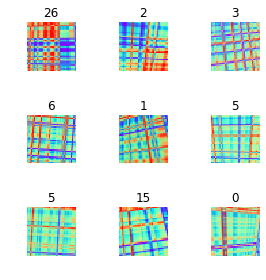

In [0]:
data.show_batch(rows=3, figsize=(4,4))

In [0]:
learn = cnn_learner(data, models.densenet121, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 71691775.53it/s]


In [0]:
learn.fit_one_cycle(epochs,callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,3.907843,3.335540,0.053488,00:06
1,3.858892,3.293045,0.046512,00:01
2,3.831823,3.276979,0.051163,00:01
3,3.754280,3.253159,0.055814,00:01
4,3.635869,3.210379,0.072093,00:01
5,3.519512,3.137792,0.106977,00:01
6,3.371968,3.050494,0.155814,00:01
7,3.218272,2.978809,0.188372,00:01
8,3.071359,2.901057,0.220930,00:01
9,2.938020,2.800445,0.241860,00:01


Better model found at epoch 0 with accuracy value: 0.05348837375640869.
Better model found at epoch 3 with accuracy value: 0.055813953280448914.
Better model found at epoch 4 with accuracy value: 0.07209302484989166.
Better model found at epoch 5 with accuracy value: 0.10697674751281738.
Better model found at epoch 6 with accuracy value: 0.15581394731998444.
Better model found at epoch 7 with accuracy value: 0.18837209045886993.
Better model found at epoch 8 with accuracy value: 0.22093023359775543.
Better model found at epoch 9 with accuracy value: 0.24186046421527863.
Better model found at epoch 10 with accuracy value: 0.262790709733963.
Better model found at epoch 13 with accuracy value: 0.2697674334049225.
Better model found at epoch 14 with accuracy value: 0.302325576543808.
Better model found at epoch 15 with accuracy value: 0.3279069662094116.
Better model found at epoch 20 with accuracy value: 0.3395348787307739.
Better model found at epoch 25 with accuracy value: 0.34186047315

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


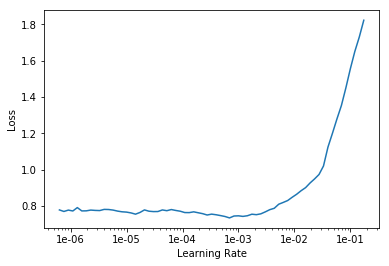

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(epochs, max_lr=slice(1e-4, 1e-3),
                    callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,0.763628,2.404944,0.346512,00:01
1,0.820351,2.366746,0.337209,00:01
2,0.855788,2.370758,0.351163,00:01
3,0.825513,2.361244,0.348837,00:01
4,0.814686,2.325112,0.358140,00:01
5,0.815013,2.300434,0.358140,00:01
6,0.793662,2.293573,0.365116,00:01
7,0.779041,2.285983,0.369767,00:01
8,0.746392,2.273206,0.379070,00:01
9,0.733832,2.297616,0.383721,00:01


Better model found at epoch 0 with accuracy value: 0.3465116322040558.
Better model found at epoch 2 with accuracy value: 0.35116279125213623.
Better model found at epoch 4 with accuracy value: 0.3581395447254181.
Better model found at epoch 6 with accuracy value: 0.36511626839637756.
Better model found at epoch 7 with accuracy value: 0.369767427444458.
Better model found at epoch 8 with accuracy value: 0.3790697753429413.
Better model found at epoch 9 with accuracy value: 0.38372093439102173.
Better model found at epoch 14 with accuracy value: 0.3883720934391022.
Better model found at epoch 15 with accuracy value: 0.40697672963142395.


In [0]:
learn.validate()

[2.1900833, tensor(0.4070)]

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)

In [0]:
accuracy(preds, y)

tensor(0.4070)

In [0]:
interp = ClassificationInterpretation(learn, preds, y, losses)

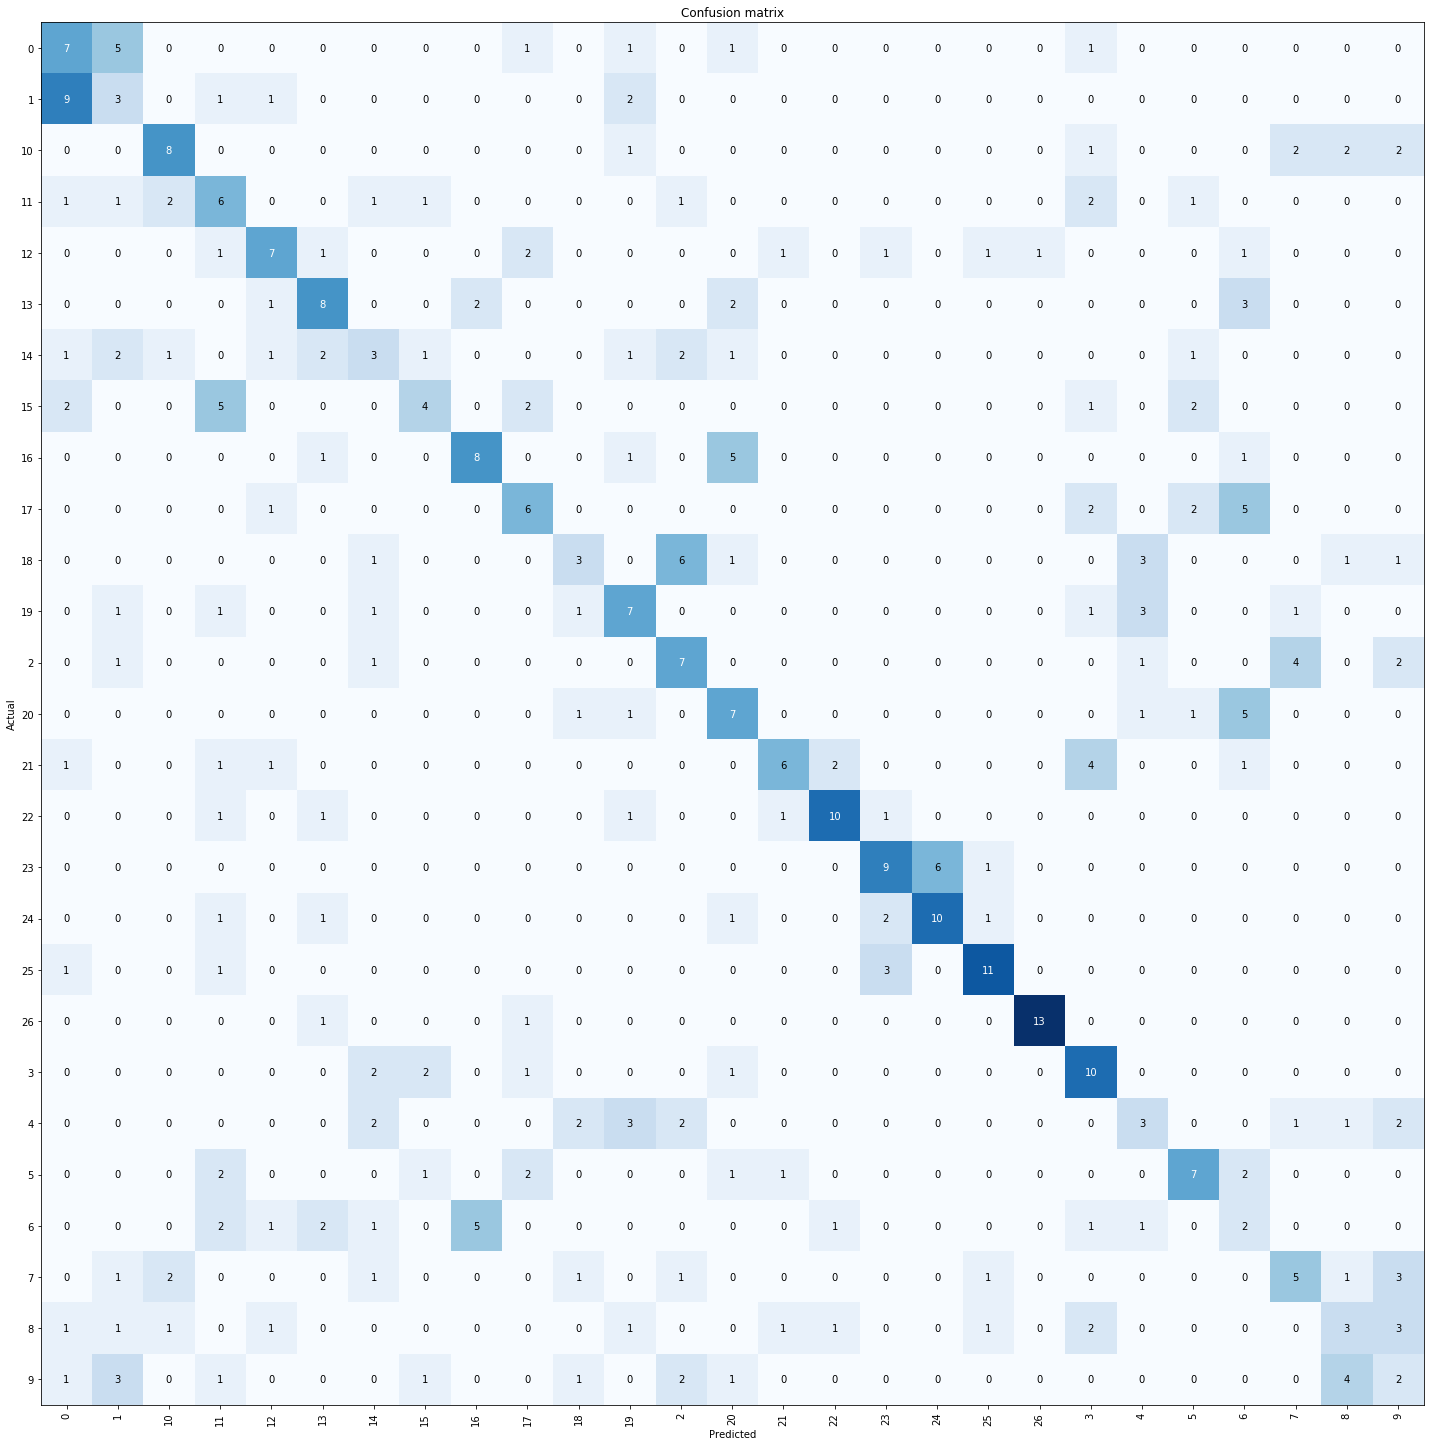

In [0]:
interp.plot_confusion_matrix(figsize=(20,20))

# Transfer Learning - gasf

In [0]:
data = ImageDataBunch.from_folder(datapath/'gasf', ds_tfms=get_transforms(do_flip=False),
                                 num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

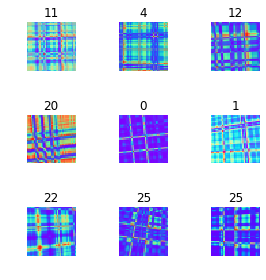

In [0]:
data.show_batch(rows=3, figsize=(4,4))

In [0]:
learn = cnn_learner(data, models.densenet121, metrics=accuracy)

In [0]:
learn.fit_one_cycle(epochs,callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,3.906162,3.364441,0.039535,00:01
1,3.859848,3.333164,0.046512,00:01
2,3.776471,3.333897,0.046512,00:01
3,3.679153,3.331301,0.046512,00:01
4,3.572656,3.289654,0.058140,00:01
5,3.461364,3.223488,0.086047,00:01
6,3.305067,3.132343,0.137209,00:01
7,3.139314,3.050267,0.158140,00:01
8,2.982320,2.989522,0.188372,00:01
9,2.828505,2.924314,0.202326,00:01


Better model found at epoch 0 with accuracy value: 0.03953488543629646.
Better model found at epoch 1 with accuracy value: 0.04651162773370743.
Better model found at epoch 4 with accuracy value: 0.058139536529779434.
Better model found at epoch 5 with accuracy value: 0.08604650944471359.
Better model found at epoch 6 with accuracy value: 0.13720929622650146.
Better model found at epoch 7 with accuracy value: 0.15813954174518585.
Better model found at epoch 8 with accuracy value: 0.18837209045886993.
Better model found at epoch 9 with accuracy value: 0.20232558250427246.
Better model found at epoch 10 with accuracy value: 0.21395349502563477.
Better model found at epoch 11 with accuracy value: 0.23255814611911774.
Better model found at epoch 12 with accuracy value: 0.2488372027873993.
Better model found at epoch 14 with accuracy value: 0.25348836183547974.
Better model found at epoch 16 with accuracy value: 0.26511627435684204.
Better model found at epoch 17 with accuracy value: 0.28604

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


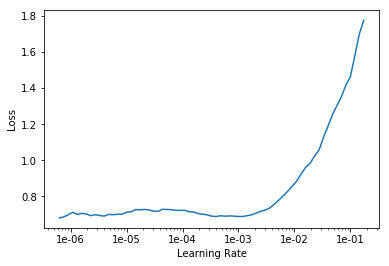

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(epochs, max_lr=slice(1e-4, 1e-3), 
                    callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,0.717033,2.780793,0.316279,00:01
1,0.718723,2.806144,0.313953,00:01
2,0.707858,2.788003,0.318605,00:01
3,0.712520,2.790999,0.302326,00:01
4,0.705050,2.773208,0.311628,00:01
5,0.674069,2.766499,0.311628,00:01
6,0.649920,2.769256,0.311628,00:01
7,0.642775,2.843855,0.318605,00:01
8,0.628952,2.977130,0.316279,00:01
9,0.622434,2.960613,0.323256,00:01


Better model found at epoch 0 with accuracy value: 0.3162790834903717.
Better model found at epoch 2 with accuracy value: 0.31860464811325073.
Better model found at epoch 9 with accuracy value: 0.3232558071613312.
Better model found at epoch 10 with accuracy value: 0.33255812525749207.
Better model found at epoch 11 with accuracy value: 0.3372093141078949.
Better model found at epoch 13 with accuracy value: 0.34418603777885437.
Better model found at epoch 14 with accuracy value: 0.35116279125213623.
Better model found at epoch 21 with accuracy value: 0.35348838567733765.
Better model found at epoch 23 with accuracy value: 0.3558139503002167.
Better model found at epoch 24 with accuracy value: 0.3604651093482971.
Better model found at epoch 30 with accuracy value: 0.36279070377349854.
Better model found at epoch 34 with accuracy value: 0.367441862821579.
Better model found at epoch 42 with accuracy value: 0.3720930218696594.
Better model found at epoch 43 with accuracy value: 0.37441861

In [0]:
learn.validate()

[2.7879133, tensor(0.3744)]

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)

In [0]:
accuracy(preds, y)

tensor(0.3744)

In [0]:
interp = ClassificationInterpretation(learn, preds, y, losses)

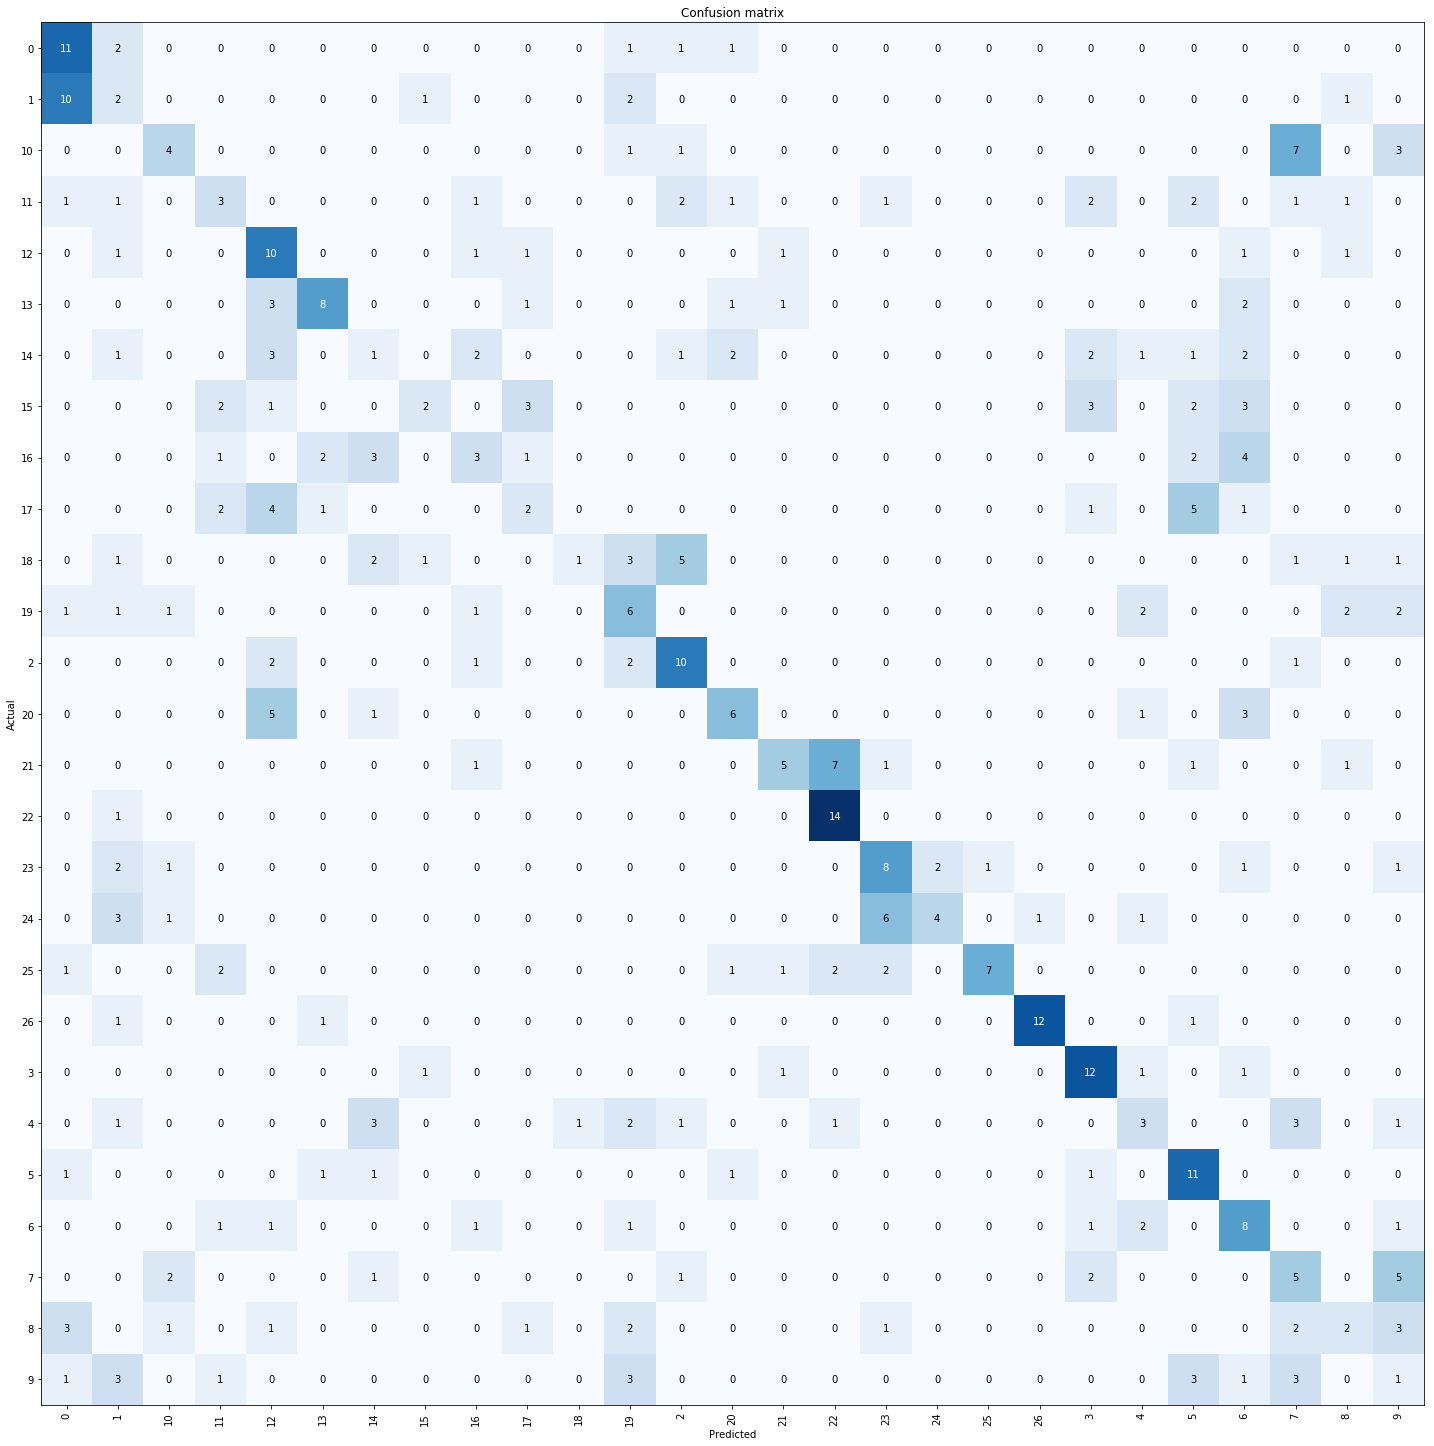

In [0]:
interp.plot_confusion_matrix(figsize=(20,20))

# Transfer Learning - mtf

In [0]:
data = ImageDataBunch.from_folder(datapath/'mtf', ds_tfms=get_transforms(do_flip=False),
                                 num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

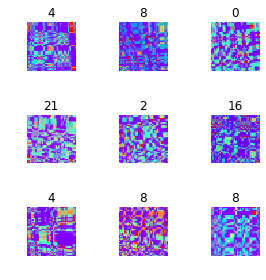

In [0]:
data.show_batch(rows=3, figsize=(4,4))

In [0]:
learn = cnn_learner(data, models.densenet121, metrics=accuracy)

In [0]:
learn.fit_one_cycle(epochs,callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,3.948693,3.344557,0.041860,00:01
1,3.860428,3.326224,0.027907,00:01
2,3.852962,3.325824,0.034884,00:01
3,3.797443,3.329386,0.039535,00:01
4,3.783538,3.334070,0.039535,00:01
5,3.744628,3.342949,0.074419,00:01
6,3.666129,3.345736,0.079070,00:01
7,3.571769,3.348504,0.069767,00:01
8,3.475664,3.370934,0.065116,00:01
9,3.399502,3.406639,0.076744,00:01


Better model found at epoch 0 with accuracy value: 0.041860464960336685.
Better model found at epoch 5 with accuracy value: 0.07441860437393188.
Better model found at epoch 6 with accuracy value: 0.07906977087259293.
Better model found at epoch 12 with accuracy value: 0.08604650944471359.
Better model found at epoch 19 with accuracy value: 0.08837209641933441.
Better model found at epoch 22 with accuracy value: 0.09069767594337463.
Better model found at epoch 23 with accuracy value: 0.09302325546741486.
Better model found at epoch 26 with accuracy value: 0.10232558101415634.


In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


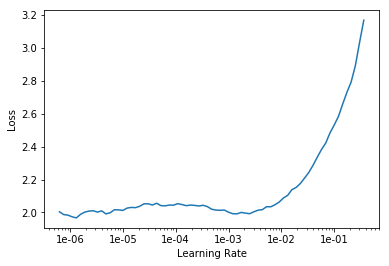

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(epochs, max_lr=slice(1e-4, 1e-3),
                    callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,2.091807,3.665224,0.104651,00:01
1,2.098554,3.674678,0.097674,00:01
2,2.034346,3.663676,0.102326,00:01
3,2.039009,3.647519,0.100000,00:01
4,2.011582,3.641916,0.106977,00:01
5,1.995548,3.643099,0.113953,00:01
6,1.963226,3.652823,0.100000,00:01
7,1.959943,3.683414,0.086047,00:01
8,1.937000,3.696435,0.081395,00:01
9,1.913197,3.679535,0.090698,00:01


Better model found at epoch 0 with accuracy value: 0.10465116053819656.
Better model found at epoch 4 with accuracy value: 0.10697674751281738.
Better model found at epoch 5 with accuracy value: 0.11395348608493805.


In [0]:
learn.validate()

[3.6430988, tensor(0.1140)]

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)

In [0]:
accuracy(preds, y)

tensor(0.1140)

In [0]:
interp = ClassificationInterpretation(learn, preds, y, losses)

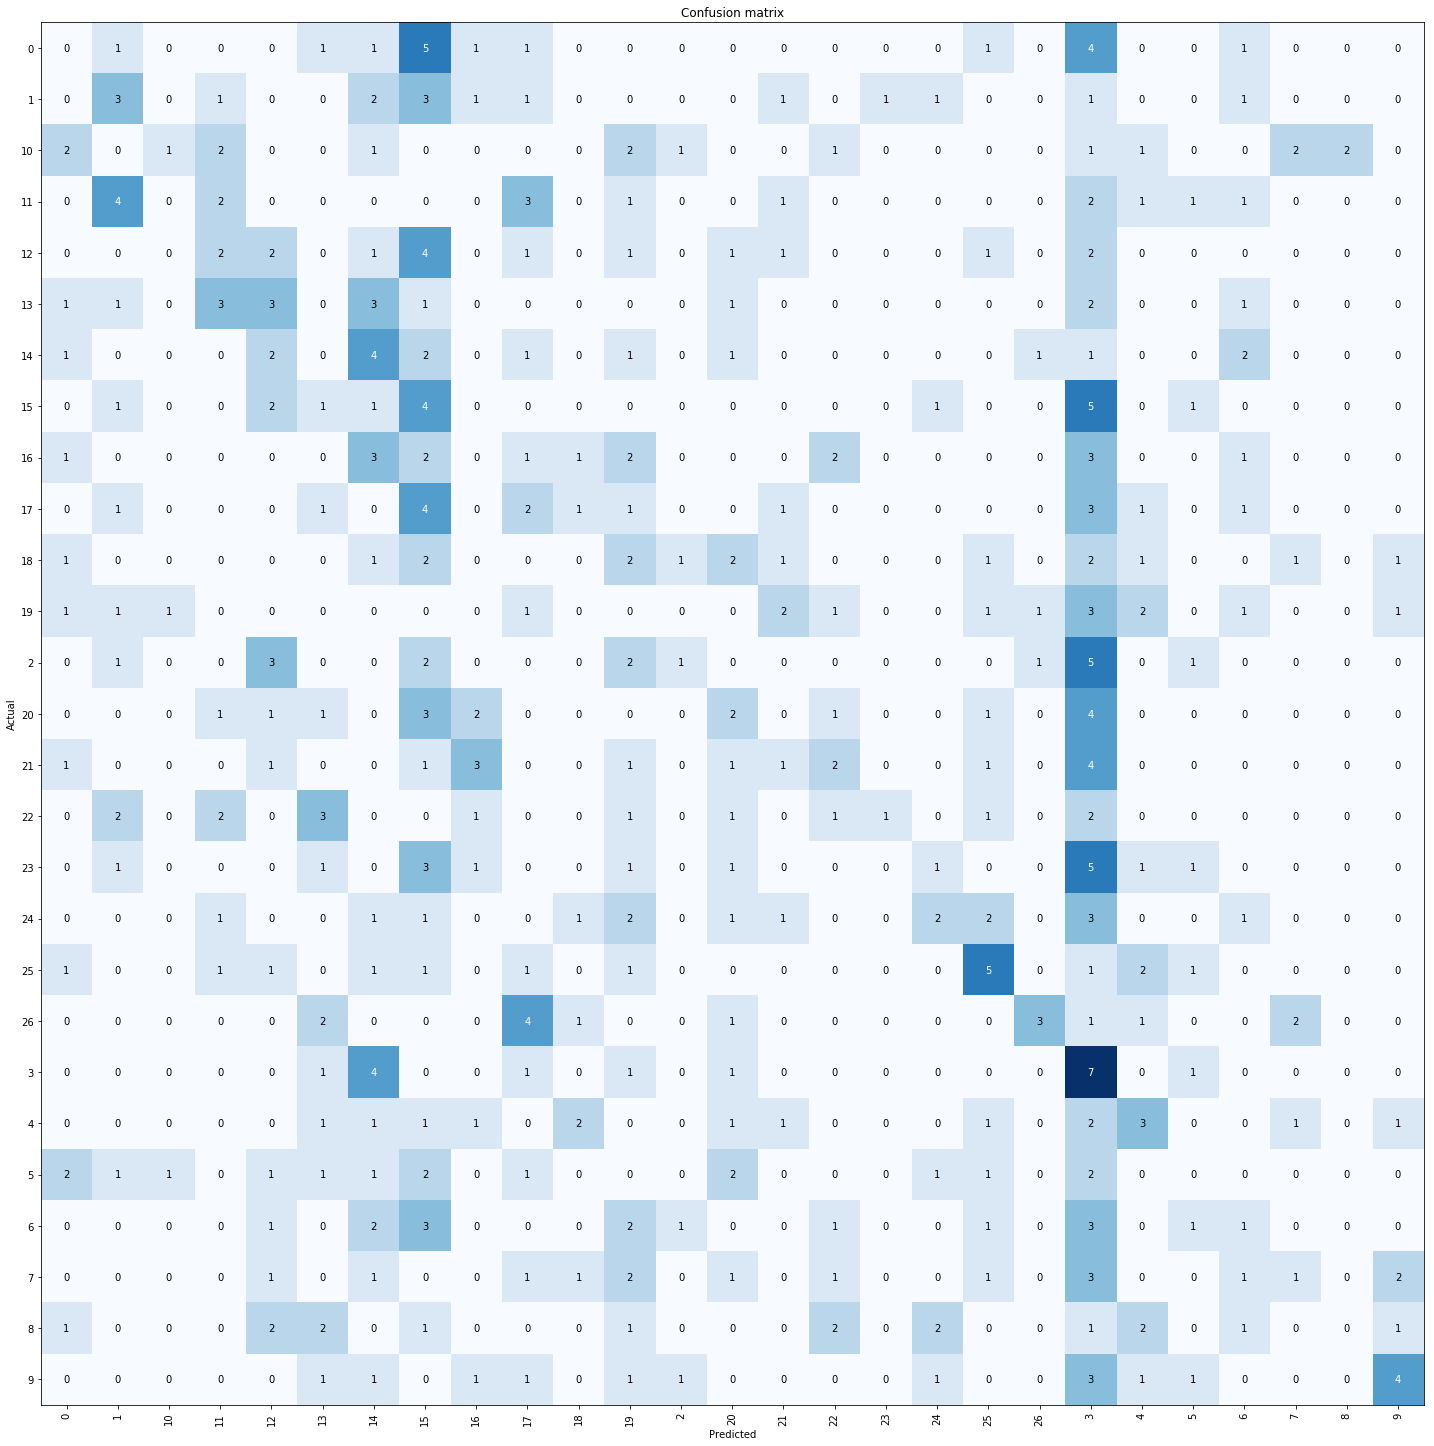

In [0]:
interp.plot_confusion_matrix(figsize=(20,20))

# Transfer Learning - rp

In [0]:
data = ImageDataBunch.from_folder(datapath/'rp', ds_tfms=get_transforms(do_flip=False),
                                 num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

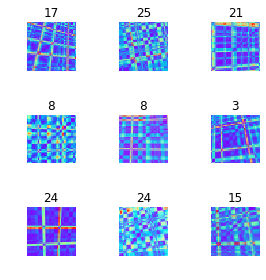

In [0]:
data.show_batch(rows=3, figsize=(4,4))

In [0]:
learn = cnn_learner(data, models.densenet121, metrics=accuracy)

In [0]:
learn.fit_one_cycle(epochs,callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,3.892240,3.360738,0.037209,00:01
1,3.843714,3.317917,0.030233,00:01
2,3.791661,3.316089,0.044186,00:01
3,3.698138,3.292312,0.058140,00:01
4,3.578272,3.244280,0.074419,00:01
5,3.444779,3.172110,0.102326,00:01
6,3.304793,3.084157,0.132558,00:01
7,3.156909,3.004435,0.155814,00:01
8,2.998736,2.907817,0.190698,00:01
9,2.864744,2.855416,0.188372,00:01


Better model found at epoch 0 with accuracy value: 0.03720930218696594.
Better model found at epoch 2 with accuracy value: 0.044186048209667206.
Better model found at epoch 3 with accuracy value: 0.058139536529779434.
Better model found at epoch 4 with accuracy value: 0.07441860437393188.
Better model found at epoch 5 with accuracy value: 0.10232558101415634.
Better model found at epoch 6 with accuracy value: 0.13255813717842102.
Better model found at epoch 7 with accuracy value: 0.15581394731998444.
Better model found at epoch 8 with accuracy value: 0.19069766998291016.
Better model found at epoch 10 with accuracy value: 0.19767442345619202.
Better model found at epoch 11 with accuracy value: 0.20465116202831268.
Better model found at epoch 12 with accuracy value: 0.23488372564315796.
Better model found at epoch 13 with accuracy value: 0.23720930516719818.
Better model found at epoch 15 with accuracy value: 0.2511627972126007.
Better model found at epoch 16 with accuracy value: 0.2720

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


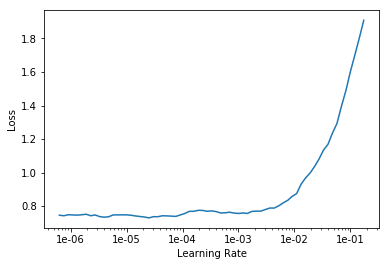

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(epochs, max_lr=slice(5e-3, 1e-3),
                    callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,0.792387,2.726052,0.318605,00:01
1,0.721706,2.765869,0.313953,00:01
2,0.707444,2.849901,0.330233,00:01
3,0.713638,2.829374,0.339535,00:01
4,0.703012,3.227250,0.313953,00:01
5,0.710090,3.475509,0.302326,00:01
6,0.717734,4.515476,0.325581,00:01
7,0.722680,4.995447,0.295349,00:01
8,0.735763,8.035967,0.293023,00:01
9,0.739684,6.609360,0.320930,00:01


Better model found at epoch 0 with accuracy value: 0.31860464811325073.
Better model found at epoch 2 with accuracy value: 0.33023256063461304.
Better model found at epoch 3 with accuracy value: 0.3395348787307739.
Better model found at epoch 14 with accuracy value: 0.3558139503002167.
Better model found at epoch 19 with accuracy value: 0.3581395447254181.
Better model found at epoch 23 with accuracy value: 0.369767427444458.
Better model found at epoch 24 with accuracy value: 0.38604649901390076.
Better model found at epoch 29 with accuracy value: 0.4046511650085449.
Better model found at epoch 30 with accuracy value: 0.4162790775299072.
Better model found at epoch 34 with accuracy value: 0.42790699005126953.
Better model found at epoch 35 with accuracy value: 0.43023255467414856.
Better model found at epoch 36 with accuracy value: 0.434883713722229.
Better model found at epoch 37 with accuracy value: 0.43953487277030945.
Better model found at epoch 40 with accuracy value: 0.441860467

In [0]:
learn.validate()

[2.637022, tensor(0.4558)]

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)

In [0]:
accuracy(preds, y)

tensor(0.4558)

In [0]:
interp = ClassificationInterpretation(learn, preds, y, losses)

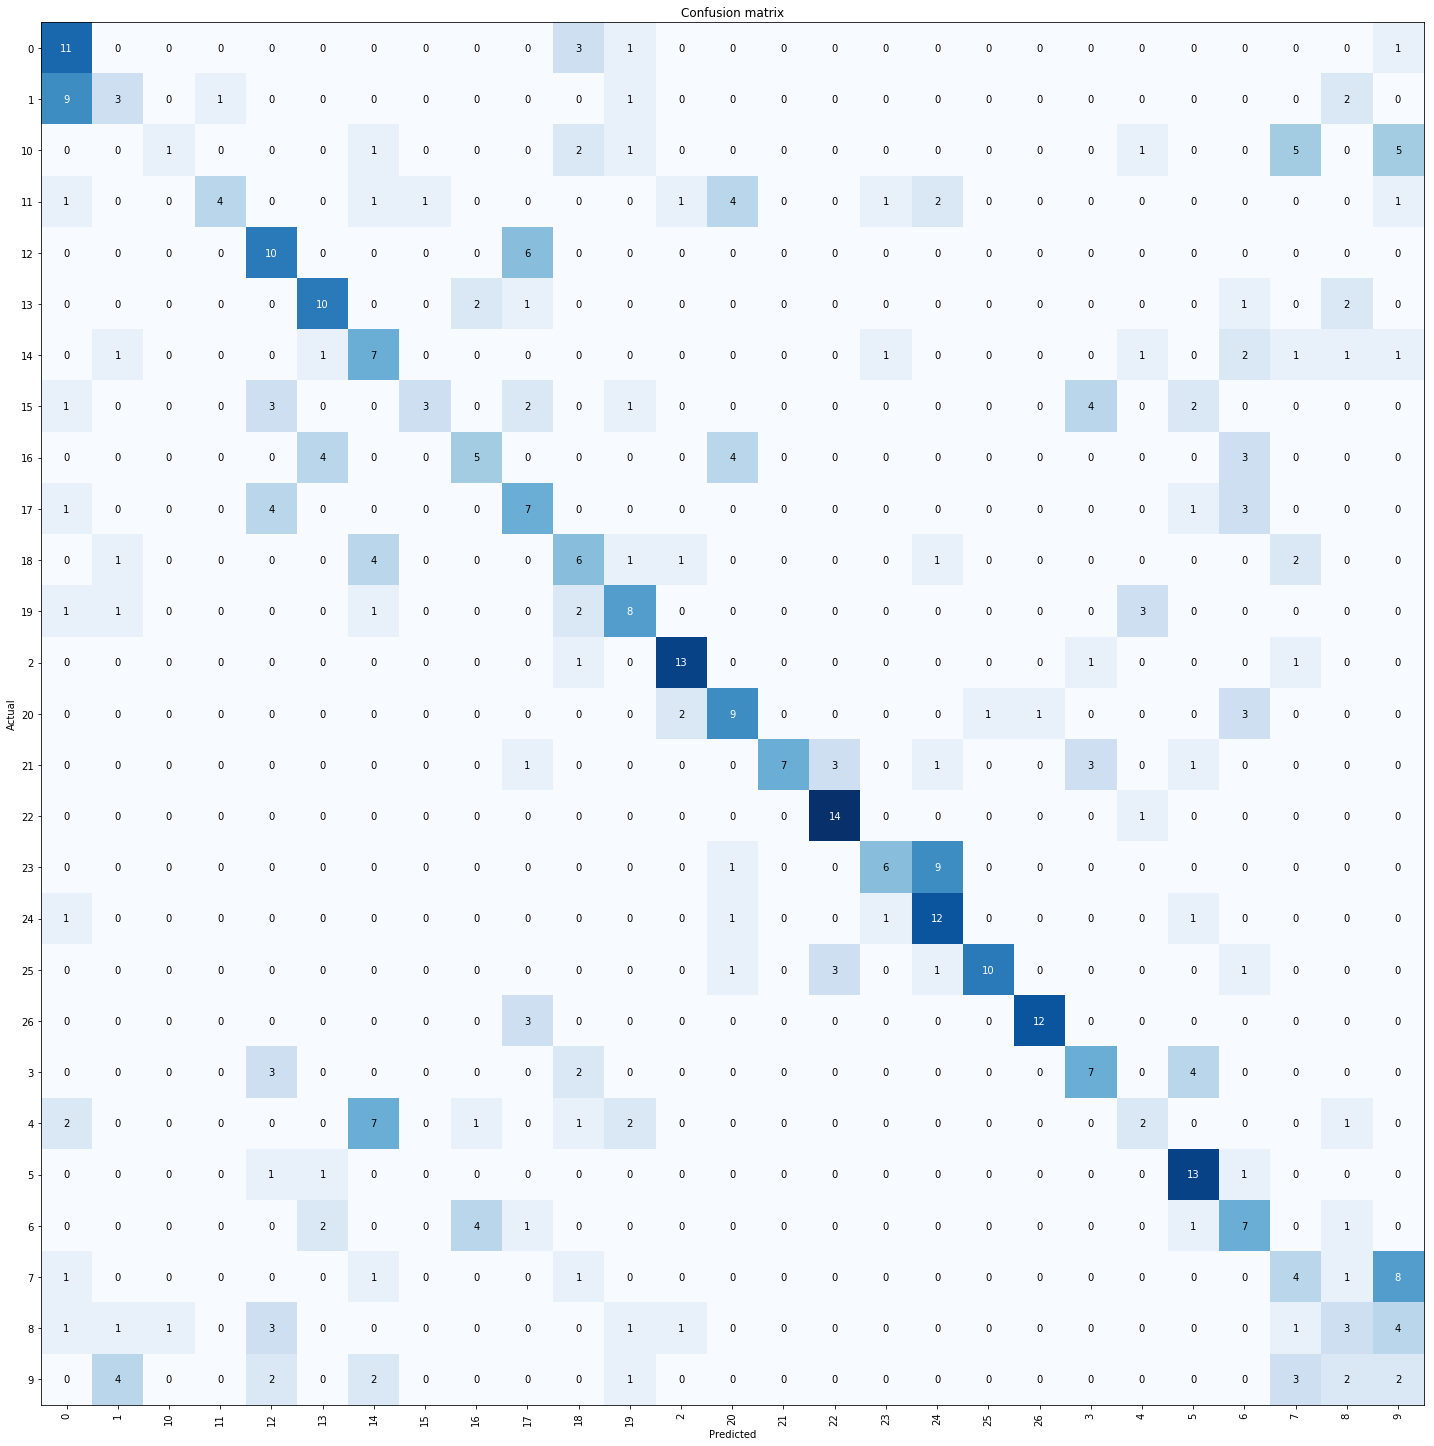

In [0]:
interp.plot_confusion_matrix(figsize=(20,20))

# Transfer Learning - gadf + rp (overlay)

In [0]:
data = ImageDataBunch.from_folder(datapath/'gadf_rp', ds_tfms=get_transforms(do_flip=False),
                                 num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

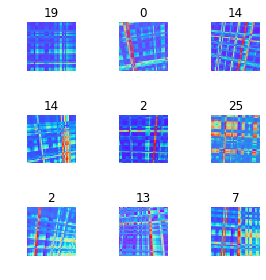

In [0]:
data.show_batch(rows=3, figsize=(4,4))

In [0]:
learn = cnn_learner(data, models.densenet121, metrics=accuracy)

In [0]:
learn.fit_one_cycle(epochs,callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,3.914067,3.321342,0.065116,00:01
1,3.853867,3.312386,0.053488,00:01
2,3.802255,3.317770,0.053488,00:01
3,3.724250,3.302882,0.065116,00:01
4,3.633535,3.275974,0.081395,00:01
5,3.506676,3.230192,0.086047,00:01
6,3.361063,3.189239,0.088372,00:01
7,3.224281,3.160839,0.100000,00:01
8,3.068882,3.156078,0.113953,00:01
9,2.944563,3.167409,0.118605,00:01


Better model found at epoch 0 with accuracy value: 0.0651162788271904.
Better model found at epoch 4 with accuracy value: 0.08139535039663315.
Better model found at epoch 5 with accuracy value: 0.08604650944471359.
Better model found at epoch 6 with accuracy value: 0.08837209641933441.
Better model found at epoch 7 with accuracy value: 0.10000000149011612.
Better model found at epoch 8 with accuracy value: 0.11395348608493805.
Better model found at epoch 9 with accuracy value: 0.11860465258359909.
Better model found at epoch 10 with accuracy value: 0.12093023210763931.
Better model found at epoch 11 with accuracy value: 0.12790697813034058.
Better model found at epoch 14 with accuracy value: 0.14651162922382355.
Better model found at epoch 15 with accuracy value: 0.1534883677959442.
Better model found at epoch 26 with accuracy value: 0.16046512126922607.
Better model found at epoch 27 with accuracy value: 0.16511628031730652.
Better model found at epoch 33 with accuracy value: 0.169767

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


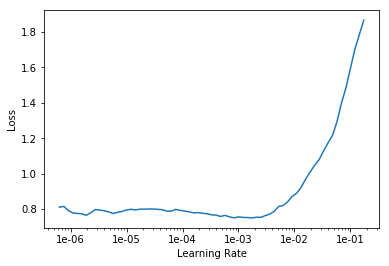

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(epochs, max_lr=slice(1e-4, 1e-3),
                    callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,0.814460,3.900189,0.186047,00:01
1,0.809182,3.892308,0.181395,00:01
2,0.791371,3.889119,0.195349,00:01
3,0.794907,3.893504,0.190698,00:01
4,0.771738,3.897395,0.186047,00:01
5,0.758860,3.916486,0.190698,00:01
6,0.756014,3.948890,0.183721,00:01
7,0.747558,3.999268,0.179070,00:01
8,0.738518,4.040726,0.188372,00:01
9,0.723556,4.084952,0.181395,00:01


Better model found at epoch 0 with accuracy value: 0.1860465109348297.
Better model found at epoch 2 with accuracy value: 0.1953488439321518.
Better model found at epoch 24 with accuracy value: 0.20000000298023224.
Better model found at epoch 25 with accuracy value: 0.20465116202831268.
Better model found at epoch 36 with accuracy value: 0.2069767415523529.
Better model found at epoch 38 with accuracy value: 0.21395349502563477.
Better model found at epoch 44 with accuracy value: 0.216279074549675.


In [0]:
learn.validate()

[4.3343115, tensor(0.2163)]

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)

In [0]:
accuracy(preds, y)

tensor(0.2163)

In [0]:
interp = ClassificationInterpretation(learn, preds, y, losses)

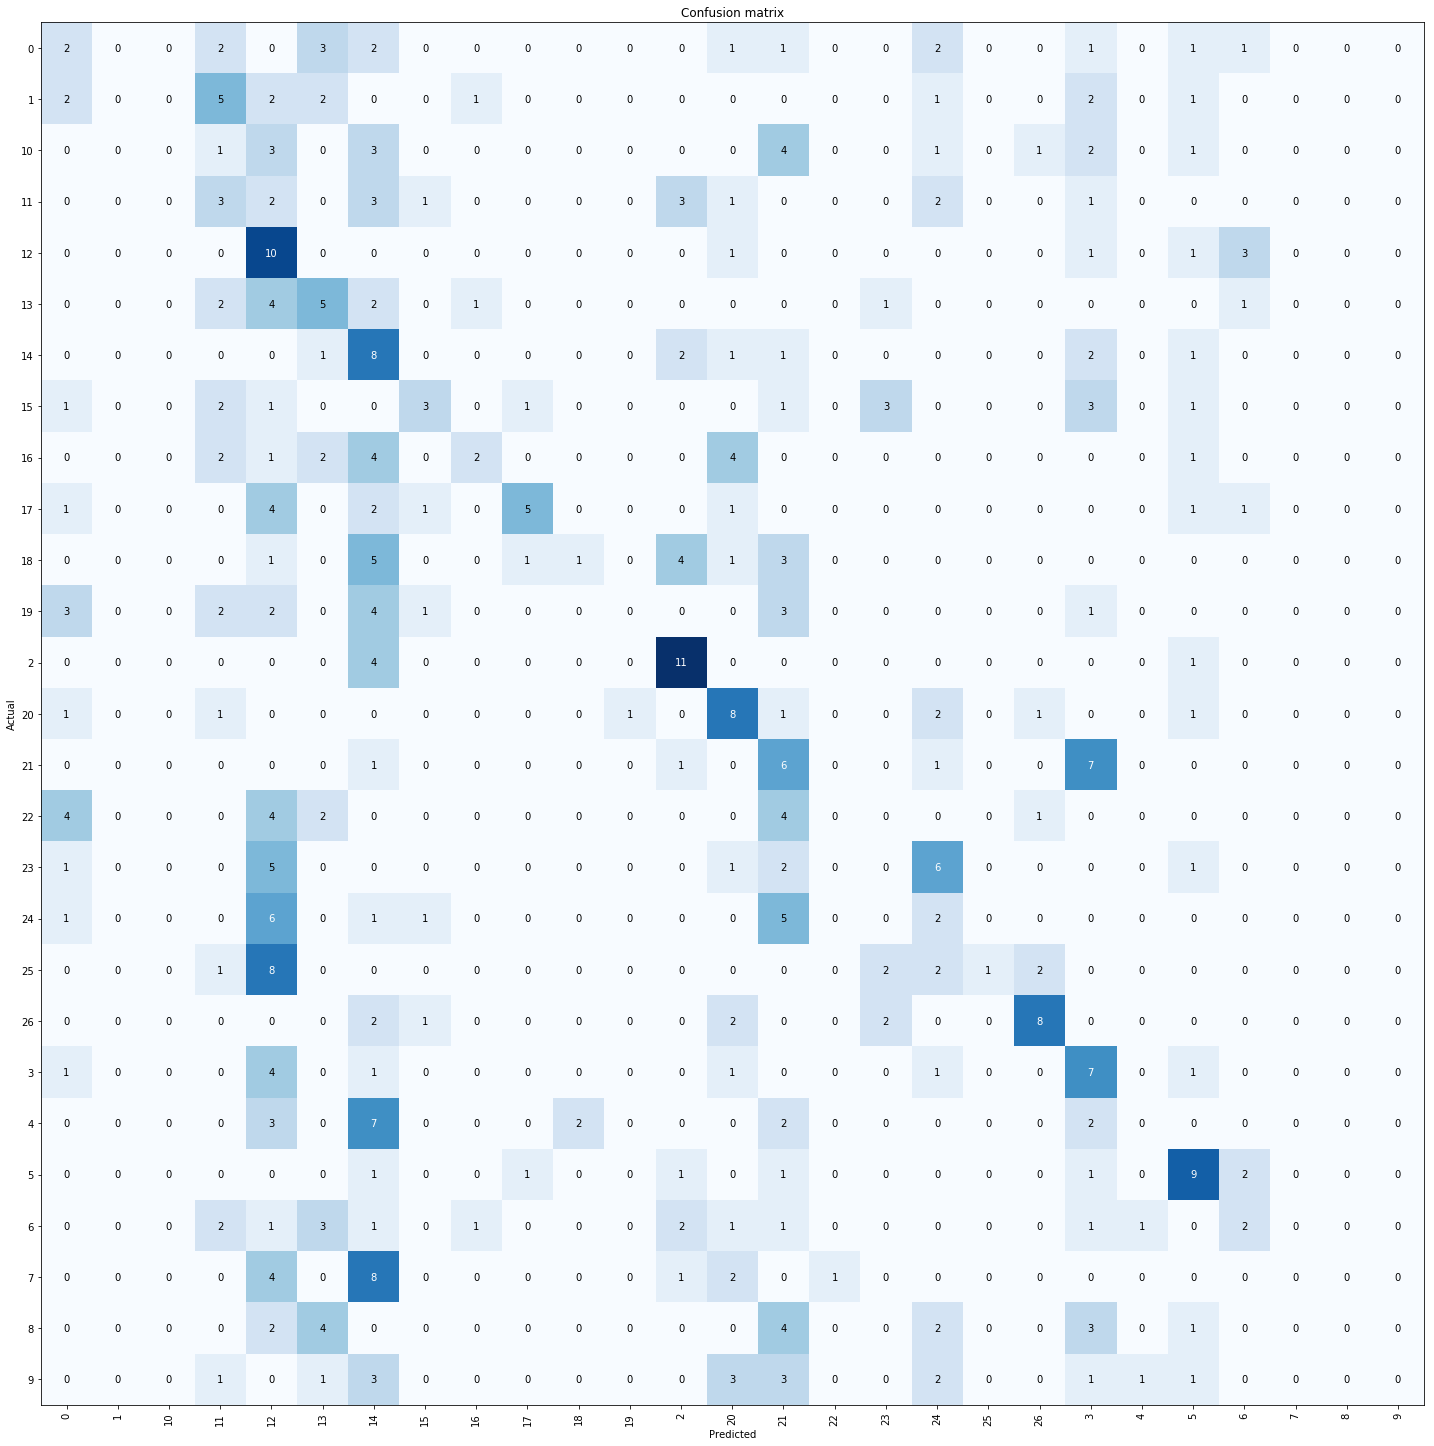

In [0]:
interp.plot_confusion_matrix(figsize=(20,20))

# Transfer Learning - all combo

In [0]:
data = ImageDataBunch.from_folder(datapath/'combo', 
                                  ds_tfms=get_transforms(do_flip=False),
                                  num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

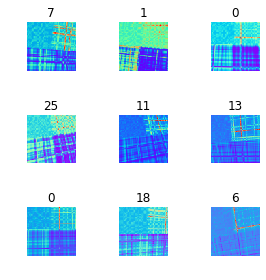

In [0]:
data.show_batch(rows=3, figsize=(4,4))

In [0]:
learn = cnn_learner(data, models.densenet121, metrics=accuracy)

In [0]:
learn.fit_one_cycle(epochs,callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,3.890766,3.398310,0.032558,00:05
1,3.793011,3.316010,0.048837,00:02
2,3.755623,3.300040,0.062791,00:02
3,3.637818,3.241158,0.062791,00:02
4,3.505565,3.152655,0.086047,00:02
5,3.333016,3.042093,0.123256,00:02
6,3.156310,2.923450,0.172093,00:02
7,2.970780,2.809944,0.202326,00:02
8,2.774135,2.711771,0.241860,00:02
9,2.575123,2.638464,0.246512,00:02


Better model found at epoch 0 with accuracy value: 0.0325581394135952.
Better model found at epoch 1 with accuracy value: 0.04883721098303795.
Better model found at epoch 2 with accuracy value: 0.06279069930315018.
Better model found at epoch 4 with accuracy value: 0.08604650944471359.
Better model found at epoch 5 with accuracy value: 0.12325581163167953.
Better model found at epoch 6 with accuracy value: 0.17209301888942719.
Better model found at epoch 7 with accuracy value: 0.20232558250427246.
Better model found at epoch 8 with accuracy value: 0.24186046421527863.
Better model found at epoch 9 with accuracy value: 0.24651162326335907.
Better model found at epoch 10 with accuracy value: 0.27674418687820435.
Better model found at epoch 11 with accuracy value: 0.2953488230705261.
Better model found at epoch 12 with accuracy value: 0.3162790834903717.
Better model found at epoch 13 with accuracy value: 0.33023256063461304.
Better model found at epoch 14 with accuracy value: 0.334883719

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


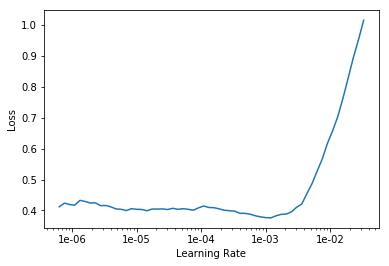

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(epochs, max_lr=slice(1e-4, 1e-3),
                    callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,0.343519,2.563376,0.386046,00:02
1,0.393580,2.561146,0.386046,00:02
2,0.367350,2.571530,0.379070,00:02
3,0.347329,2.541645,0.369767,00:02
4,0.353499,2.513620,0.381395,00:02
5,0.363837,2.486372,0.379070,00:02
6,0.343873,2.474617,0.381395,00:02
7,0.338059,2.482105,0.374419,00:02
8,0.326130,2.529085,0.369767,00:02
9,0.312790,2.554708,0.379070,00:02


Better model found at epoch 0 with accuracy value: 0.38604649901390076.
Better model found at epoch 10 with accuracy value: 0.3930232524871826.
Better model found at epoch 13 with accuracy value: 0.4023255705833435.
Better model found at epoch 14 with accuracy value: 0.40930232405662537.
Better model found at epoch 19 with accuracy value: 0.4116279184818268.
Better model found at epoch 22 with accuracy value: 0.4139534831047058.
Better model found at epoch 25 with accuracy value: 0.41860464215278625.
Better model found at epoch 27 with accuracy value: 0.4255813956260681.
Better model found at epoch 28 with accuracy value: 0.42790699005126953.
Better model found at epoch 31 with accuracy value: 0.43953487277030945.


In [0]:
learn.validate()

[2.7276342, tensor(0.4395)]

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)

In [0]:
accuracy(preds, y)

tensor(0.4395)

In [0]:
interp = ClassificationInterpretation(learn, preds, y, losses)

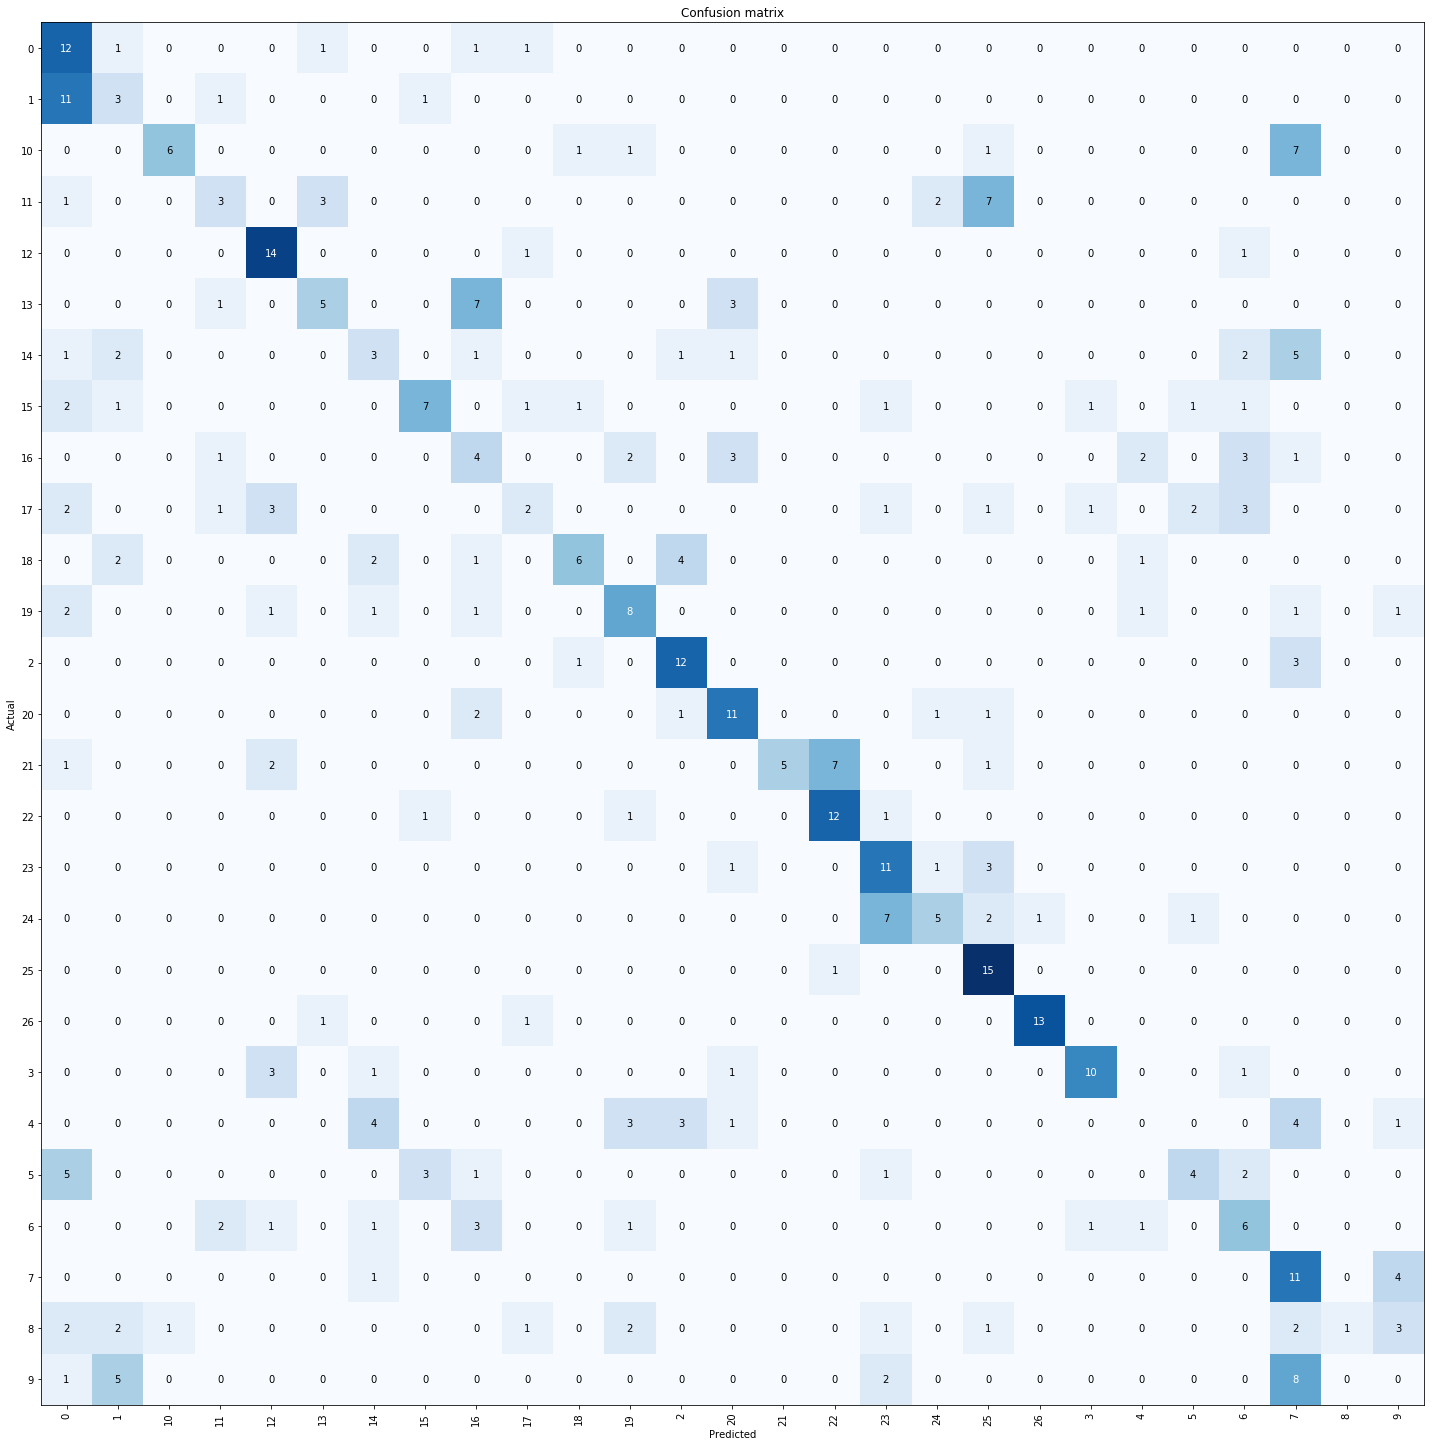

In [0]:
interp.plot_confusion_matrix(figsize=(20,20))